In [ ]:
# Following https://github.com/nci/FourCastNet/blob/main/notebooks/inference.ipynb

In [1]:
import sys
import time
import numpy as np
import argparse
from numpy.core.numeric import False_
import h5py
import torch
import torchvision
from torchvision.utils import save_image
import torch.nn as nn
import torch.cuda.amp as amp
import torch.distributed as dist
from collections import OrderedDict
from torch.nn.parallel import DistributedDataParallel
import logging
from utils import logging_utils
from utils.weighted_acc_rmse import weighted_rmse_torch_channels, weighted_acc_torch_channels, unweighted_acc_torch_channels, weighted_acc_masked_torch_channels
logging_utils.config_logger()
from utils.YParams import YParams
from utils.data_loader_multifiles import get_data_loader
from networks.afnonet import AFNONet
import wandb
import matplotlib.pyplot as plt
import glob
from datetime import datetime
from matplotlib.widgets import Slider
import time
import matplotlib.colors as colors
import matplotlib.image as mpimg
from matplotlib import rcParams
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import hvplot.pandas
import zarr
%matplotlib inline 

/storage/homefs/no21h426/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from inference_nci import data_loader
namelist=[]
for i in range(20):
    namelist.append(data_loader.channel_to_var(i))
namelist

['10u',
 '10v',
 '2t',
 'sp',
 'msl',
 't850',
 'u1000',
 'v1000',
 'z1000',
 'u850',
 'v850',
 'z850',
 'u500',
 'v500',
 'z500',
 't500',
 'z50',
 'r500',
 'r850',
 'tcwv']

In [3]:
# The channel names in the order of stored array.
namelist=['u10','v10','t2m','sp','msl',
          't850','u1000','v1000','z1000','u850',
          'v850','z850','u500','v500','z500',
          't500','z50','r500','r850','tcwv']

In [7]:
file = '/storage/workspaces/giub_hydro/hydro/data/Global_hourly/out_of_sample21/2021.h5'
file2 = '/storage/workspaces/giub_hydro/hydro/data/Global_hourly/out_sample2018/2018.h5'

In [8]:
# Open h5py file
f = h5py.File(file, 'r')

In [9]:
f['fields']

<HDF5 dataset "fields": shape (1460, 21, 721, 1440), type "<f4">

In [10]:
f2 = h5py.File(file2, 'r')

In [11]:
f2['fields'].shape

(1460, 21, 721, 1440)

In [24]:
variables = ['u10', 'v10', 't2m', 'sp', 'mslp', 't850', 'u1000', 'v1000', 'z1000', 'u850', 'v850', 'z850', 'u500', 'v500', 'z500', 't500', 'z50', 'r500', 'r850', 'tcwv', 'sst']

# variables description dictionary
variables_description = {
    'u10': '10 metre U wind component [m/s]',
    'v10': '10 metre V wind component [m/s]',
    't2m': '2 metre temperature [K]',
    'sp': 'Surface pressure [Pa]',
    'mslp': 'Mean sea level pressure [Pa]',
    't850': 'Temperature at 850 hPa [K]',
    'u1000': '1000 metre U wind component [m/s]',
    'v1000': '1000 metre V wind component [m/s]',
    'z1000': '1000 metre geopotential [m^2/s^2]',
    'u850': '850 metre U wind component [m/s]',
    'v850': '850 metre V wind component [m/s]',
    'z850': '850 metre geopotential [m^2/s^2]',
    'u500': '500 metre U wind component [m/s]',
    'v500': '500 metre V wind component [m/s]',
    'z500': '500 metre geopotential [m^2/s^2]',
    't500': 'Temperature at 500 hPa [K]',
    'z50': '50 metre geopotential [m^2/s^2]',
    'r500': 'Relative humidity at 500 hPa [%]',
    'r850': 'Relative humidity at 850 hPa [%]',
    'tcwv': 'Total column water vapour [kg/m^2]',
    'sst': 'Sea surface temperature [K]' #?
}

In [12]:
def check_inputs(ff):
    n_figs = ff['fields'].shape[1]
    ncols = 5
    nrows = -(-n_figs // ncols)
    fig, axes = plt.subplots(figsize=(24, 3.3*nrows), ncols=ncols, nrows=nrows)

    for i in range(f['fields'].shape[1]):

        i_row = i // ncols
        i_col = i % ncols
        ax = axes[i_row, i_col]

        data = ff['fields'][:, i, :, :].mean(axis=0, keepdims=True)
        data = data.squeeze()
        image = ax.imshow(data)
        plt.colorbar(image, ax=ax)  # Add a colorbar to the plot

    plt.show()  # Display all the subplots together


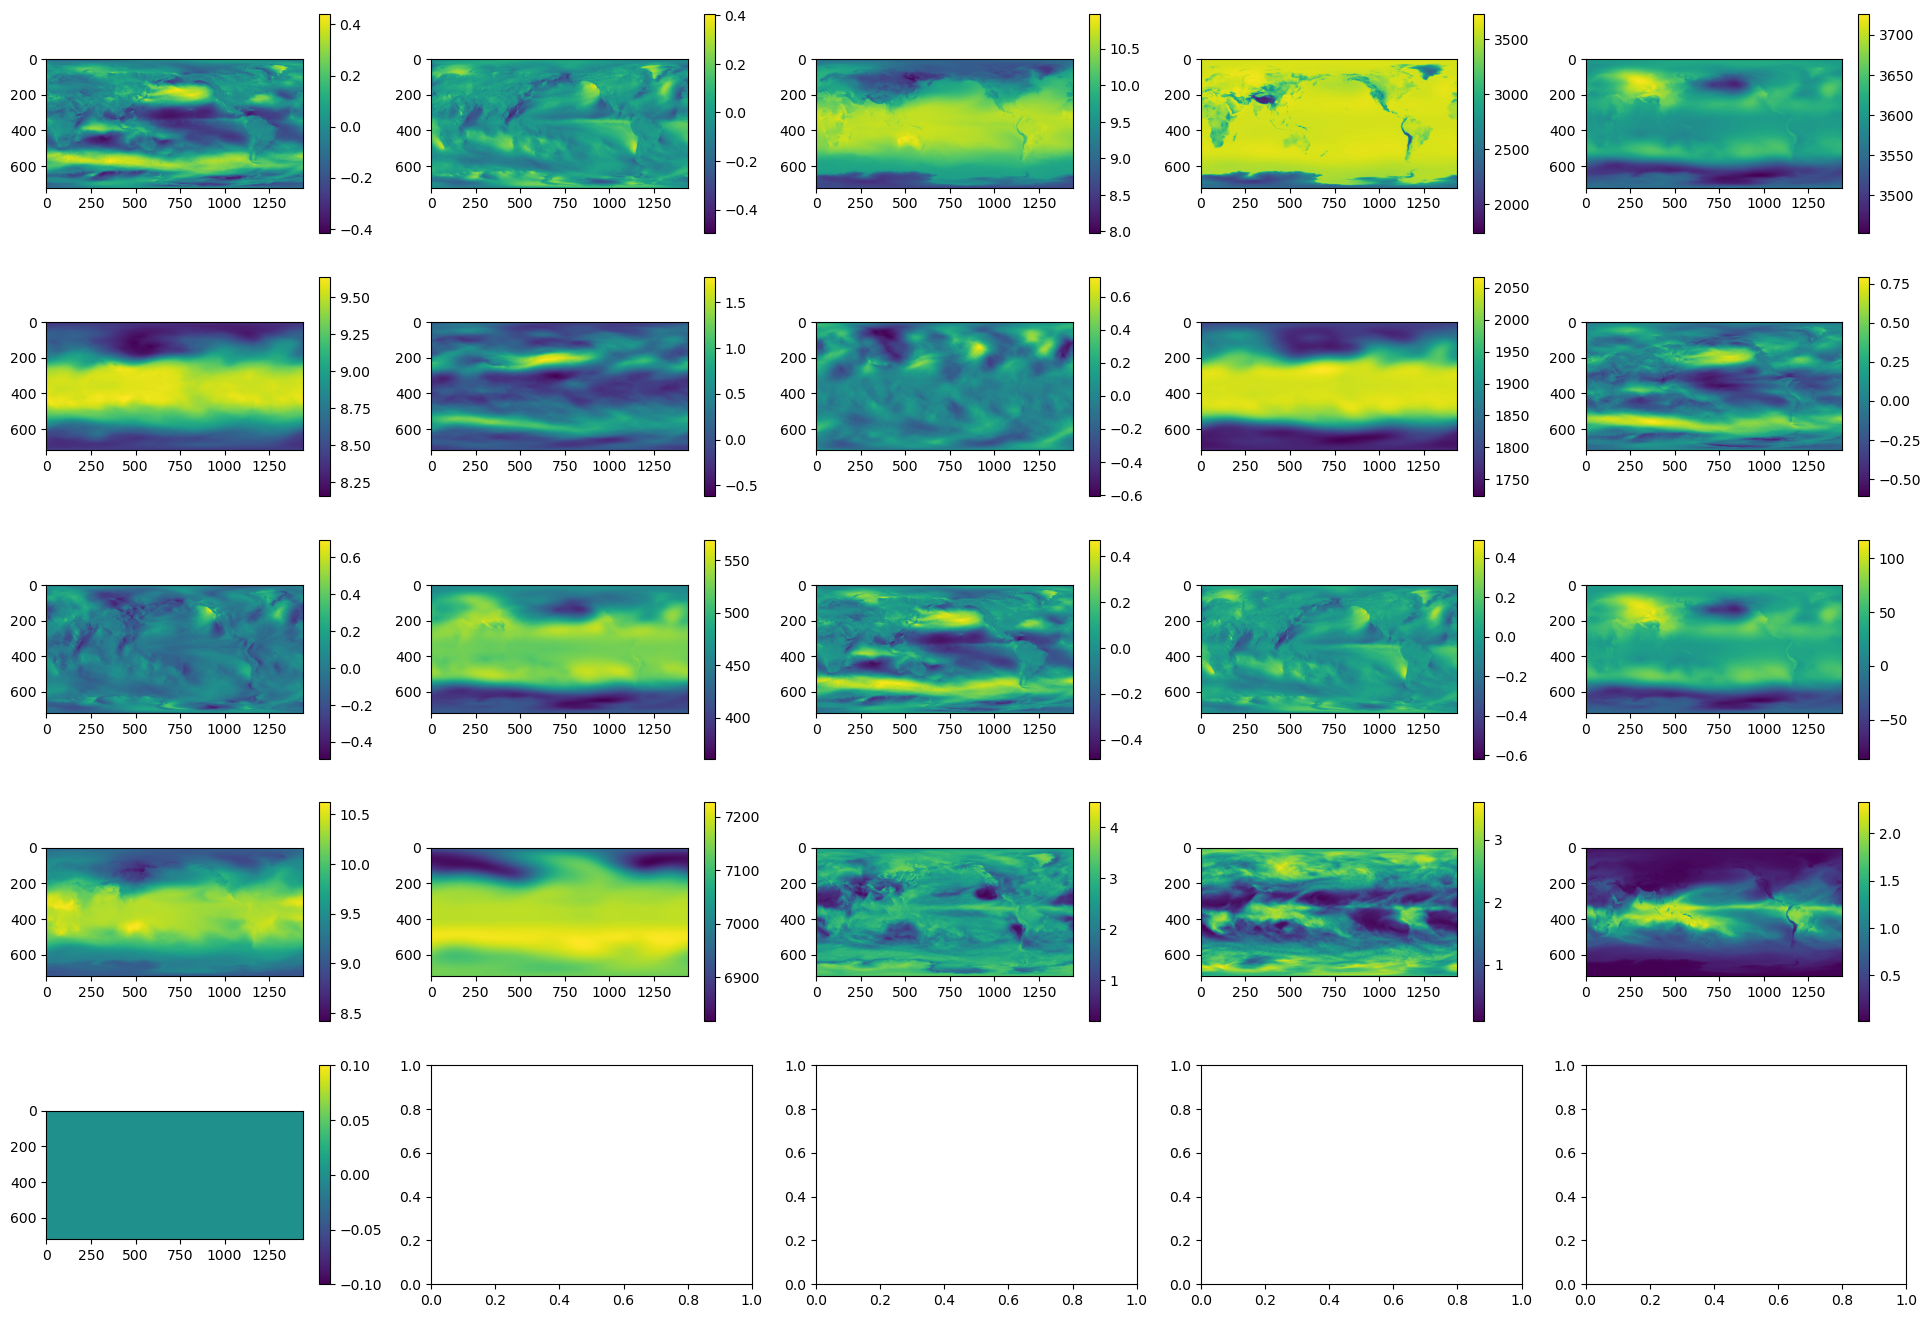

In [13]:
# visualize means
# Plot each variable - 2021
check_inputs(f)

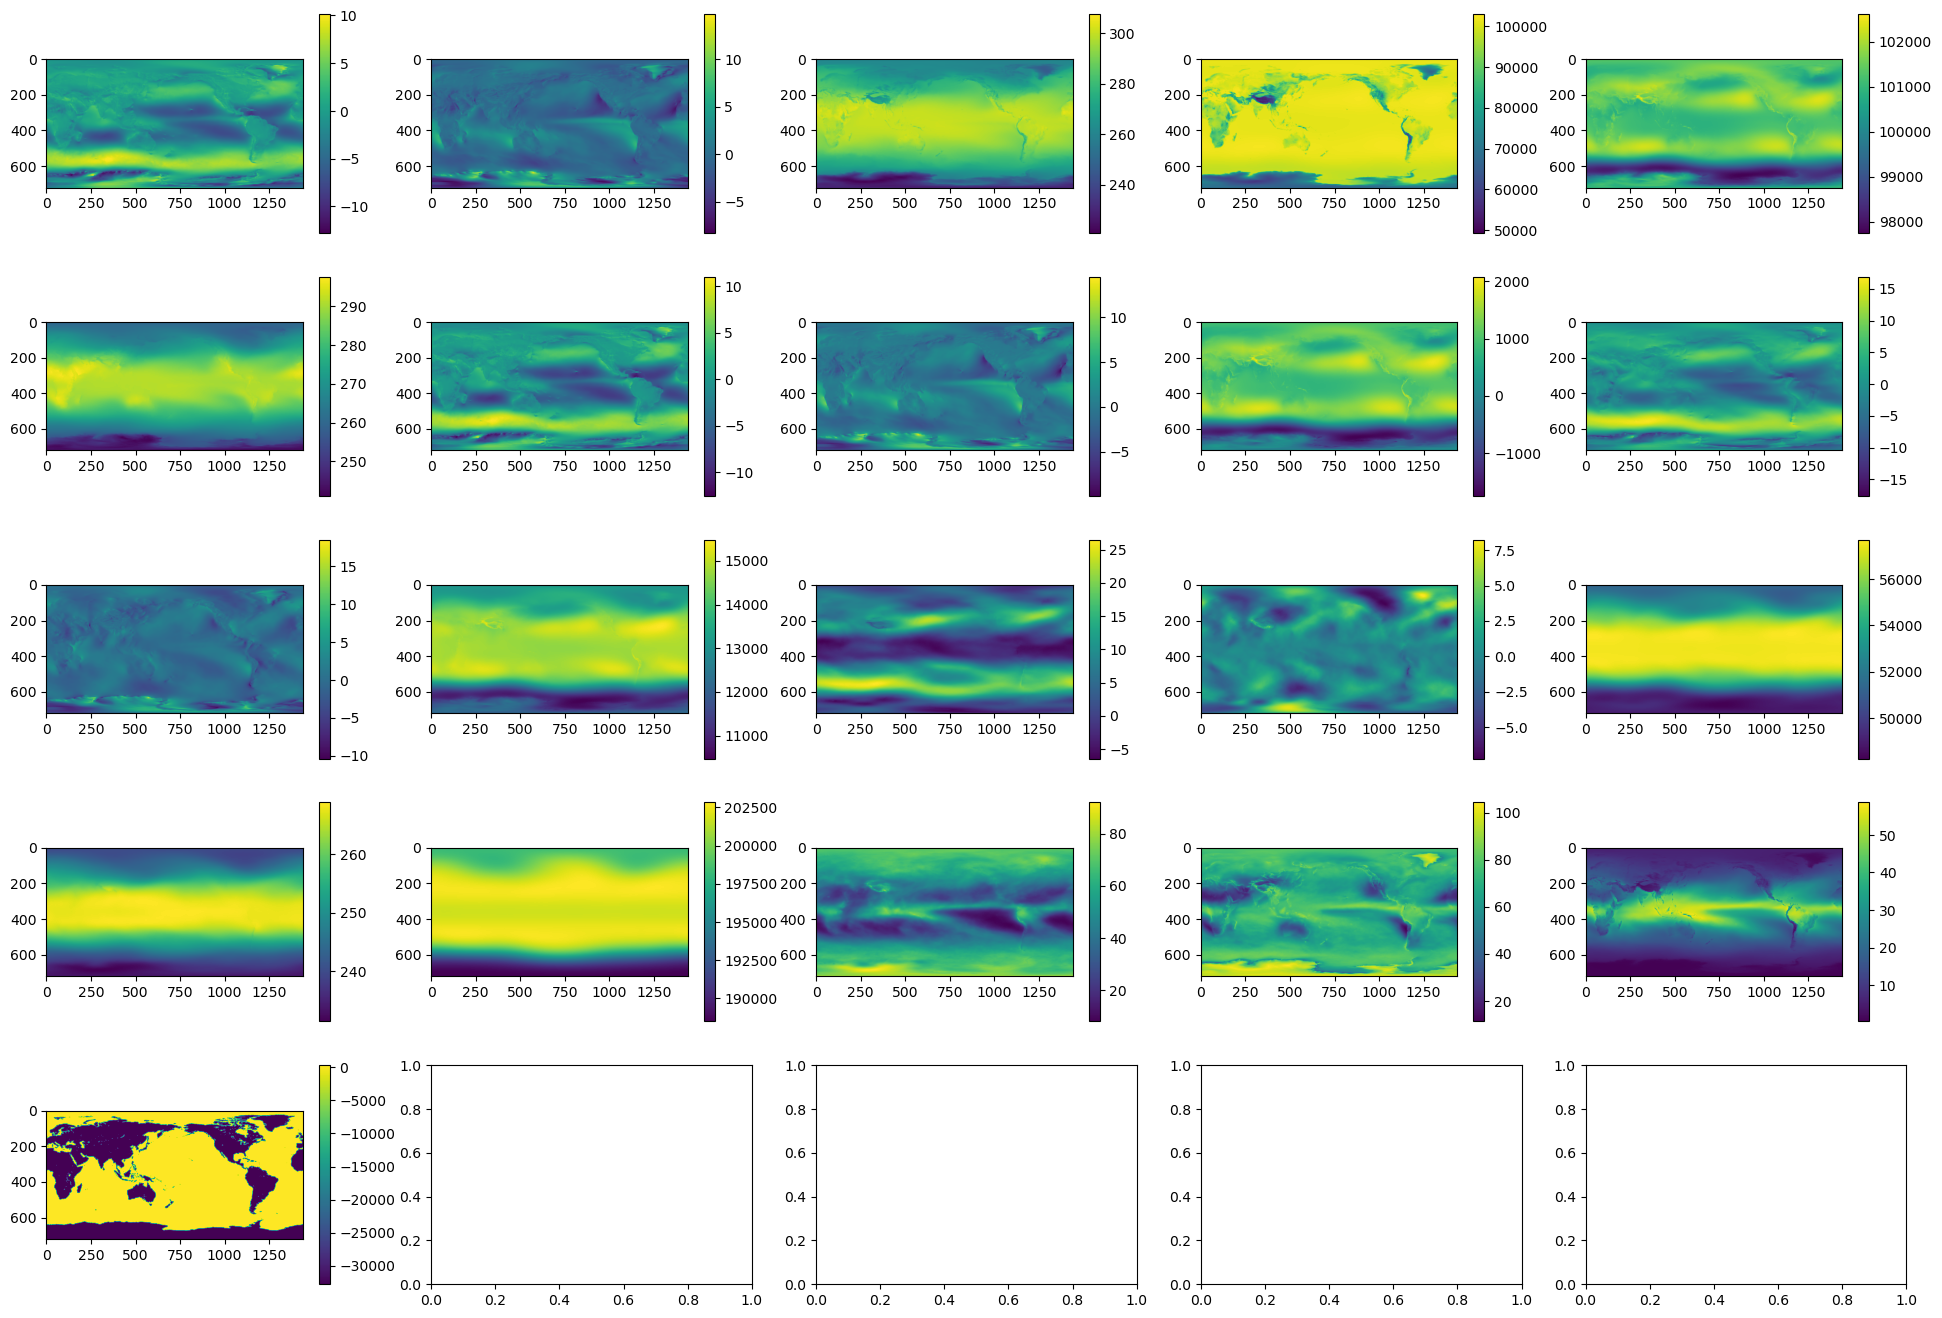

In [14]:
# 2018
check_inputs(f2)

In [25]:
# 7 days slice
start = 1072 # around Nov 13
end = start +  7*4 # 3 days * 4 time steps per day
data_sliced21 = f['fields'][start:end, :, :, :]
data_sliced18 = f2['fields'][start:end, :, :, :]

In [31]:
f2['fields'][1:2, :, :, :]

array([[[[ 2.6881990e-01,  2.6881990e-01,  2.6881990e-01, ...,
           2.6881990e-01,  2.6881990e-01,  2.6881990e-01],
         [-1.9469709e+00, -1.9480476e+00, -1.9491242e+00, ...,
          -1.9383576e+00, -1.9415876e+00, -1.9448175e+00],
         [-1.6411961e+00, -1.6433494e+00, -1.6455028e+00, ...,
          -1.6282760e+00, -1.6336594e+00, -1.6390427e+00],
         ...,
         [-1.9695810e+00, -1.9534310e+00, -1.9275908e+00, ...,
          -2.0363348e+00, -2.0083413e+00, -1.9846544e+00],
         [-1.3181945e+00, -1.3020444e+00, -1.2848177e+00, ...,
          -1.3623381e+00, -1.3472646e+00, -1.3332679e+00],
         [ 5.4983127e-01,  5.4983127e-01,  5.4983127e-01, ...,
           5.4983127e-01,  5.4983127e-01,  5.4983127e-01]],

        [[-1.6003816e-01, -1.6003816e-01, -1.6003816e-01, ...,
          -1.6003816e-01, -1.6003816e-01, -1.6003816e-01],
         [-1.5721532e+00, -1.5666629e+00, -1.5622706e+00, ...,
          -1.5864282e+00, -1.5820358e+00, -1.5765455e+00],
        

In [32]:
f['fields'][1:2, :, :, :]

array([[[[-1.2904693e-01, -1.2904693e-01, -1.2904693e-01, ...,
          -1.2904693e-01, -1.2904693e-01, -1.2904693e-01],
         [-7.9647303e+00, -7.9523497e+00, -7.9388437e+00, ...,
          -7.9939933e+00, -7.9849892e+00, -7.9748597e+00],
         [-8.0097504e+00, -7.9939933e+00, -7.9726086e+00, ...,
          -8.0558949e+00, -8.0367622e+00, -8.0221300e+00],
         ...,
         [-3.5314128e+00, -3.5280364e+00, -3.5212834e+00, ...,
          -3.5381658e+00, -3.5347893e+00, -3.5325382e+00],
         [-3.5651774e+00, -3.5606756e+00, -3.5561736e+00, ...,
          -3.5719304e+00, -3.5696795e+00, -3.5674286e+00],
         [ 1.6470678e-01,  1.6470678e-01,  1.6470678e-01, ...,
           1.6470678e-01,  1.6470678e-01,  1.6470678e-01]],

        [[-3.2887337e-01, -3.2887337e-01, -3.2887337e-01, ...,
          -3.2887337e-01, -3.2887337e-01, -3.2887337e-01],
         [ 4.5449657e+00,  4.5587220e+00,  4.5724778e+00, ...,
           4.4941750e+00,  4.5100470e+00,  4.5269775e+00],
        

In [26]:
data_sliced21

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    